In [1]:
# (token方向に)AvgPool -> (embed方向に)LayerNorm
# 0.1はwarmup
# 

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='025'
    debug=False  # False
    wandb=True
    resume= None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=16
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=1
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Thu Jun 16 14:40:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    44W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 25.4 ms, sys: 28.7 ms, total: 54.1 ms
Wall time: 1.25 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        # id='3bwalqa8',
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [ ]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
tqdm.pandas()
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [ ]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [ ]:
# ';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

In [12]:
# anchor, target, context_text をそれぞれ一文ずつとみなす
# anchorとtarget逆順にも並べる
train['text'] = train['anchor'] + '.' + ' [SEP] ' + train['target'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text'] = test['anchor'] + '.' + ' [SEP] ' + test['target'] + '.' + ' [SEP] '  + test['context_text'] + '.'
train['text_rev'] = train['target'] + '.' + ' [SEP] ' + train['anchor'] + '.' + ' [SEP] '  + train['context_text'] + '.'
test['text_rev'] = test['target'] + '.' + ' [SEP] ' + test['anchor'] + '.' + ' [SEP] '  + test['context_text'] + '.'
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text,text_rev
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] abatement of pollution. [SEP]...,abatement of pollution. [SEP] abatement. [SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] act of abating. [SEP] HUMAN N...,act of abating. [SEP] abatement. [SEP] HUMAN N...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] active catalyst. [SEP] HUMAN ...,active catalyst. [SEP] abatement. [SEP] HUMAN ...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] eliminating process. [SEP] HU...,eliminating process. [SEP] abatement. [SEP] HU...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...,abatement. [SEP] forest region. [SEP] HUMAN NE...,forest region. [SEP] abatement. [SEP] HUMAN NE...


,id,anchor,target,context,context_text,text,text_rev
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum. [SEP] inorganic photoconductor drum....,inorganic photoconductor drum. [SEP] opc drum....
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,adjust gas flow. [SEP] altering gas flow. [SEP...,altering gas flow. [SEP] adjust gas flow. [SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...,lower trunnion. [SEP] lower locating. [SEP] PE...,lower locating. [SEP] lower trunnion. [SEP] PE...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...,cap component. [SEP] upper portion. [SEP] TEXT...,upper portion. [SEP] cap component. [SEP] TEXT...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation. [SEP] artificial neural ne...,artificial neural network. [SEP] neural stimul...


# EDA

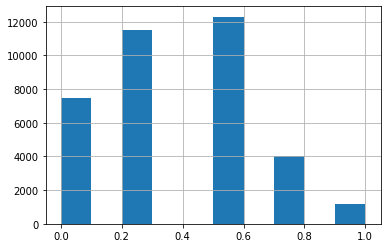

In [13]:
train['score'].hist()

In [14]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [15]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [16]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [17]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [18]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 106


In [ ]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [ ]:
# train_dataset = TrainDataset(CFG, train, 'train')
# inputs, label = train_dataset[0]
# print(inputs)
# print(label)

# Model

In [ ]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self.layer_norm1 = nn.LayerNorm(self.config.hidden_size)
        self._init_weights(self.attention)
        self.linear = nn.Linear(self.config.hidden_size, 1)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_state = outputs[0]
        input_mask_expanded = inputs["attention_mask"].unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        out = sum_embeddings / sum_mask
        
        out = self.layer_norm1(out)
        output = self.fc(out)
                
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    CFG.num_warmup_steps = num_train_steps * 0.1
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    # if wandb.run.resumed:
    #     checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
    #     if checkpoint['epoch'] < CFG.epochs-1:  # foldの終わりで止まっている時もある
    #         model.load_state_dict(checkpoint['model'])
    #         optimizer.load_state_dict(checkpoint['optimizer'])
    #         scheduler.load_state_dict(checkpoint['scheduler'])
    #         # amp.load_state_dict(checkpoint['amp'])
    #         epoch = checkpoint['epoch'] + 1  # 保存時のエポックが読み出されるので+1
    #         best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [24]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/1693] Elapsed 0m 0s (remain 27m 50s) Loss: 0.7058(0.7058) Grad: inf  LR: 0.00000002  
Epoch: [1][100/1693] Elapsed 1m 18s (remain 20m 31s) Loss: 0.5910(0.6620) Grad: 16719.8652  LR: 0.00000239  
Epoch: [1][200/1693] Elapsed 2m 35s (remain 19m 13s) Loss: 0.5637(0.6410) Grad: 20466.3848  LR: 0.00000475  
Epoch: [1][300/1693] Elapsed 3m 52s (remain 17m 56s) Loss: 0.5928(0.6264) Grad: 18428.4492  LR: 0.00000711  
Epoch: [1][400/1693] Elapsed 5m 9s (remain 16m 38s) Loss: 0.6088(0.6158) Grad: 44352.7188  LR: 0.00000947  
Epoch: [1][500/1693] Elapsed 6m 27s (remain 15m 21s) Loss: 0.6475(0.6073) Grad: 34880.0938  LR: 0.00001184  
Epoch: [1][600/1693] Elapsed 7m 44s (remain 14m 4s) Loss: 0.5919(0.6020) Grad: 31375.8438  LR: 0.00001420  
Epoch: [1][700/1693] Elapsed 9m 2s (remain 12m 47s) Loss: 0.5534(0.5956) Grad: 44121.3945  LR: 0.00001656  
Epoch: [1][800/1693] Elapsed 10m 19s (remain 11m 29s) Loss: 0.6040(0.5932) Grad: 15525.6035  LR: 0.00001892  
Epoch: [1][900/1693] Elapsed 11

Epoch 1 - avg_train_loss: 0.5702  avg_val_loss: 0.5508  time: 1428s
Epoch 1 - Score: 0.8164


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6796(0.5508) 


Epoch 1 - Save Best Score: 0.8164 Model


Epoch: [2][0/1693] Elapsed 0m 1s (remain 51m 50s) Loss: 0.6231(0.6231) Grad: 65384.3320  LR: 0.00001940  
Epoch: [2][100/1693] Elapsed 1m 21s (remain 21m 22s) Loss: 0.6807(0.5205) Grad: 119643.6016  LR: 0.00001925  
Epoch: [2][200/1693] Elapsed 2m 38s (remain 19m 37s) Loss: 0.5208(0.5226) Grad: 40118.1680  LR: 0.00001908  
Epoch: [2][300/1693] Elapsed 3m 56s (remain 18m 11s) Loss: 0.5516(0.5246) Grad: 102303.8125  LR: 0.00001890  
Epoch: [2][400/1693] Elapsed 5m 13s (remain 16m 49s) Loss: 0.5840(0.5242) Grad: 41082.0234  LR: 0.00001871  
Epoch: [2][500/1693] Elapsed 6m 30s (remain 15m 29s) Loss: 0.4648(0.5249) Grad: 46939.8398  LR: 0.00001850  
Epoch: [2][600/1693] Elapsed 7m 47s (remain 14m 10s) Loss: 0.5088(0.5242) Grad: 26512.7480  LR: 0.00001827  
Epoch: [2][700/1693] Elapsed 9m 5s (remain 12m 51s) Loss: 0.4854(0.5219) Grad: 29558.3340  LR: 0.00001803  
Epoch: [2][800/1693] Elapsed 10m 22s (remain 11m 33s) Loss: 0.5019(0.5210) Grad: 60670.9062  LR: 0.00001778  
Epoch: [2][900/1693]

Epoch 2 - avg_train_loss: 0.5196  avg_val_loss: 0.5402  time: 1432s
Epoch 2 - Score: 0.8399
Epoch 2 - Save Best Score: 0.8399 Model


Epoch: [3][0/1693] Elapsed 0m 0s (remain 27m 59s) Loss: 0.6038(0.6038) Grad: inf  LR: 0.00001500  
Epoch: [3][100/1693] Elapsed 1m 20s (remain 21m 2s) Loss: 0.4928(0.5104) Grad: 37200.5859  LR: 0.00001464  
Epoch: [3][200/1693] Elapsed 2m 37s (remain 19m 30s) Loss: 0.5763(0.5098) Grad: 23302.1426  LR: 0.00001427  
Epoch: [3][300/1693] Elapsed 3m 55s (remain 18m 6s) Loss: 0.5895(0.5044) Grad: 44503.1914  LR: 0.00001389  
Epoch: [3][400/1693] Elapsed 5m 12s (remain 16m 46s) Loss: 0.4764(0.5036) Grad: 72583.0938  LR: 0.00001351  
Epoch: [3][500/1693] Elapsed 6m 29s (remain 15m 27s) Loss: 0.5545(0.5064) Grad: 59050.9180  LR: 0.00001312  
Epoch: [3][600/1693] Elapsed 7m 47s (remain 14m 8s) Loss: 0.4089(0.5042) Grad: 14311.1631  LR: 0.00001272  
Epoch: [3][700/1693] Elapsed 9m 4s (remain 12m 50s) Loss: 0.4578(0.5049) Grad: 21834.2031  LR: 0.00001233  
Epoch: [3][800/1693] Elapsed 10m 21s (remain 11m 32s) Loss: 0.5913(0.5042) Grad: 35201.6406  LR: 0.00001192  
Epoch: [3][900/1693] Elapsed 11m

Epoch 3 - avg_train_loss: 0.5057  avg_val_loss: 0.5538  time: 1431s
Epoch 3 - Score: 0.8396


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6697(0.5538) 
Epoch: [4][0/1693] Elapsed 0m 1s (remain 30m 10s) Loss: 0.6109(0.6109) Grad: 23151.9746  LR: 0.00000826  
Epoch: [4][100/1693] Elapsed 1m 19s (remain 20m 55s) Loss: 0.5235(0.4981) Grad: 73871.7969  LR: 0.00000786  
Epoch: [4][200/1693] Elapsed 2m 37s (remain 19m 26s) Loss: 0.5664(0.4965) Grad: 64689.9219  LR: 0.00000746  
Epoch: [4][300/1693] Elapsed 3m 54s (remain 18m 5s) Loss: 0.4894(0.4961) Grad: 179765.9375  LR: 0.00000706  
Epoch: [4][400/1693] Elapsed 5m 12s (remain 16m 45s) Loss: 0.4134(0.4977) Grad: 56705.8398  LR: 0.00000667  
Epoch: [4][500/1693] Elapsed 6m 29s (remain 15m 26s) Loss: 0.5859(0.4955) Grad: 174761.9531  LR: 0.00000628  
Epoch: [4][600/1693] Elapsed 7m 46s (remain 14m 8s) Loss: 0.4667(0.4961) Grad: 92793.2578  LR: 0.00000590  
Epoch: [4][700/1693] Elapsed 9m 4s (remain 12m 50s) Loss: 0.4125(0.4956) Grad: 41540.5664  LR: 0.00000553  
Epoch: [4][800/1693] Elapsed 10m 21s (remain 11m 32s) Loss: 0.36

Epoch 4 - avg_train_loss: 0.4950  avg_val_loss: 0.5514  time: 1432s
Epoch 4 - Score: 0.8424


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6726(0.5514) 


Epoch 4 - Save Best Score: 0.8424 Model


Epoch: [5][0/1693] Elapsed 0m 1s (remain 36m 35s) Loss: 0.5080(0.5080) Grad: 37638.3555  LR: 0.00000234  
Epoch: [5][100/1693] Elapsed 1m 20s (remain 21m 2s) Loss: 0.5258(0.4823) Grad: 83792.6797  LR: 0.00000208  
Epoch: [5][200/1693] Elapsed 2m 37s (remain 19m 31s) Loss: 0.4896(0.4820) Grad: 18813.5918  LR: 0.00000184  
Epoch: [5][300/1693] Elapsed 3m 55s (remain 18m 7s) Loss: 0.5923(0.4853) Grad: 33913.1758  LR: 0.00000160  
Epoch: [5][400/1693] Elapsed 5m 12s (remain 16m 47s) Loss: 0.5745(0.4875) Grad: 146572.7969  LR: 0.00000139  
Epoch: [5][500/1693] Elapsed 6m 29s (remain 15m 27s) Loss: 0.5807(0.4888) Grad: 41213.5586  LR: 0.00000119  
Epoch: [5][600/1693] Elapsed 7m 47s (remain 14m 9s) Loss: 0.6039(0.4886) Grad: 150167.4844  LR: 0.00000100  
Epoch: [5][700/1693] Elapsed 9m 4s (remain 12m 50s) Loss: 0.5375(0.4889) Grad: 62926.4961  LR: 0.00000083  
Epoch: [5][800/1693] Elapsed 10m 22s (remain 11m 32s) Loss: 0.5391(0.4884) Grad: 49486.6719  LR: 0.00000067  
Epoch: [5][900/1693] El

Epoch 5 - avg_train_loss: 0.4917  avg_val_loss: 0.5598  time: 1432s
Epoch 5 - Score: 0.8393


EVAL: [586/587] Elapsed 1m 59s (remain 0m 0s) Loss: 0.6701(0.5598) 


========== fold: 0 result ==========
Score: 0.8424
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1725] Elapsed 0m 1s (remain 35m 10s) Loss: 0.6627(0.6627) Grad: inf  LR: 0.00000002  
Epoch: [1][100/1725] Elapsed 1m 19s (remain 21m 19s) Loss: 0.6555(0.6446) Grad: 18375.5078  LR: 0.00000234  
Epoch: [1][200/1725] Elapsed 2m 37s (remain 19m 50s) Loss: 0.6881(0.6373) Grad: 36033.2148  LR: 0.00000466  
Epoch: [1][300/1725] Elapsed 3m 54s (remain 18m 29s) Loss: 0.6043(0.6256) Grad: 19287.9648  LR: 0.00000698  
Epoch: [1][400/1725] Elapsed 5m 11s (remain 17m 9s) Loss: 0.5853(0.6171) Grad: 20528.0215  LR: 0.00000929  
Epoch: [1][500/1725] Elapsed 6m 29s (remain 15m 51s) Loss: 0.5120(0.6088) Grad: 20712.7305  LR: 0.00001161  
Epoch: [1][600/1725] Elapsed 7m 46s (remain 14m 33s) Loss: 0.5977(0.6015) Grad: 37343.2852  LR: 0.00001393  
Epoch: [1][700/1725] Elapsed 9m 4s (remain 13m 15s) Loss: 0.6110(0.5966) Grad: 22191.5137  LR: 0.00001625  
Epoch: [1][800/1725] Elapsed 10m 21s (remain 11m 57s) Loss: 0.5234(0.5933) Grad: 6912.2988  LR: 0.00001857  
Epoch: [1][900/1725] Elapsed 11

Epoch 1 - avg_train_loss: 0.5672  avg_val_loss: 0.5743  time: 1450s
Epoch 1 - Score: 0.8012


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4974(0.5743) 


Epoch 1 - Save Best Score: 0.8012 Model


Epoch: [2][0/1725] Elapsed 0m 1s (remain 37m 18s) Loss: 0.6431(0.6431) Grad: 102225.5391  LR: 0.00001940  
Epoch: [2][100/1725] Elapsed 1m 21s (remain 21m 42s) Loss: 0.5398(0.5418) Grad: 124265.9453  LR: 0.00001925  
Epoch: [2][200/1725] Elapsed 2m 38s (remain 20m 0s) Loss: 0.5241(0.5387) Grad: 47324.2188  LR: 0.00001909  
Epoch: [2][300/1725] Elapsed 3m 55s (remain 18m 35s) Loss: 0.5972(0.5269) Grad: 26657.9824  LR: 0.00001891  
Epoch: [2][400/1725] Elapsed 5m 13s (remain 17m 13s) Loss: 0.6234(0.5261) Grad: 21034.3027  LR: 0.00001872  
Epoch: [2][500/1725] Elapsed 6m 30s (remain 15m 54s) Loss: 0.5425(0.5261) Grad: 30831.1094  LR: 0.00001852  
Epoch: [2][600/1725] Elapsed 7m 48s (remain 14m 35s) Loss: 0.6660(0.5265) Grad: 85005.7031  LR: 0.00001830  
Epoch: [2][700/1725] Elapsed 9m 5s (remain 13m 17s) Loss: 0.5203(0.5260) Grad: 41089.2695  LR: 0.00001807  
Epoch: [2][800/1725] Elapsed 10m 23s (remain 11m 59s) Loss: 0.4757(0.5248) Grad: 38702.5820  LR: 0.00001782  
Epoch: [2][900/1725] 

Epoch 2 - avg_train_loss: 0.5192  avg_val_loss: 0.5493  time: 1453s
Epoch 2 - Score: 0.8265


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4994(0.5493) 


Epoch 2 - Save Best Score: 0.8265 Model


Epoch: [3][0/1725] Elapsed 0m 1s (remain 31m 17s) Loss: 0.5286(0.5286) Grad: 24848.8262  LR: 0.00001500  
Epoch: [3][100/1725] Elapsed 1m 20s (remain 21m 33s) Loss: 0.5913(0.5105) Grad: 141480.7969  LR: 0.00001465  
Epoch: [3][200/1725] Elapsed 2m 38s (remain 20m 0s) Loss: 0.6011(0.5096) Grad: 33760.5508  LR: 0.00001429  
Epoch: [3][300/1725] Elapsed 3m 55s (remain 18m 35s) Loss: 0.5553(0.5082) Grad: 49802.7539  LR: 0.00001392  
Epoch: [3][400/1725] Elapsed 5m 13s (remain 17m 14s) Loss: 0.3957(0.5076) Grad: 73574.3516  LR: 0.00001354  
Epoch: [3][500/1725] Elapsed 6m 30s (remain 15m 54s) Loss: 0.4067(0.5059) Grad: 49946.1562  LR: 0.00001316  
Epoch: [3][600/1725] Elapsed 7m 48s (remain 14m 35s) Loss: 0.4959(0.5054) Grad: 181744.1562  LR: 0.00001277  
Epoch: [3][700/1725] Elapsed 9m 5s (remain 13m 17s) Loss: 0.4996(0.5055) Grad: 76157.9531  LR: 0.00001238  
Epoch: [3][800/1725] Elapsed 10m 23s (remain 11m 58s) Loss: 0.5553(0.5062) Grad: 58168.2422  LR: 0.00001199  
Epoch: [3][900/1725] 

Epoch 3 - avg_train_loss: 0.5043  avg_val_loss: 0.5774  time: 1452s
Epoch 3 - Score: 0.8178


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4937(0.5774) 
Epoch: [4][0/1725] Elapsed 0m 1s (remain 30m 29s) Loss: 0.6275(0.6275) Grad: 142412.8750  LR: 0.00000827  
Epoch: [4][100/1725] Elapsed 1m 20s (remain 21m 27s) Loss: 0.5590(0.5072) Grad: 79491.1250  LR: 0.00000787  
Epoch: [4][200/1725] Elapsed 2m 37s (remain 19m 54s) Loss: 0.5089(0.5027) Grad: 81999.5938  LR: 0.00000748  
Epoch: [4][300/1725] Elapsed 3m 55s (remain 18m 32s) Loss: 0.5136(0.5008) Grad: 41542.2969  LR: 0.00000709  
Epoch: [4][400/1725] Elapsed 5m 12s (remain 17m 12s) Loss: 0.5257(0.5013) Grad: 219968.2812  LR: 0.00000670  
Epoch: [4][500/1725] Elapsed 6m 30s (remain 15m 53s) Loss: 0.4762(0.5027) Grad: 100517.1797  LR: 0.00000633  
Epoch: [4][600/1725] Elapsed 7m 47s (remain 14m 34s) Loss: 0.3820(0.5002) Grad: 102015.4922  LR: 0.00000595  
Epoch: [4][700/1725] Elapsed 9m 5s (remain 13m 16s) Loss: 0.5526(0.5009) Grad: 89687.2266  LR: 0.00000559  
Epoch: [4][800/1725] Elapsed 10m 22s (remain 11m 58s) Loss: 

Epoch 4 - avg_train_loss: 0.4966  avg_val_loss: 0.5674  time: 1452s
Epoch 4 - Score: 0.8238


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4938(0.5674) 
Epoch: [5][0/1725] Elapsed 0m 1s (remain 30m 20s) Loss: 0.2829(0.2829) Grad: 60735.1289  LR: 0.00000235  
Epoch: [5][100/1725] Elapsed 1m 19s (remain 21m 21s) Loss: 0.5311(0.4988) Grad: 377350.5938  LR: 0.00000209  
Epoch: [5][200/1725] Elapsed 2m 37s (remain 19m 51s) Loss: 0.5085(0.5017) Grad: 19413.0430  LR: 0.00000185  
Epoch: [5][300/1725] Elapsed 3m 54s (remain 18m 30s) Loss: 0.4610(0.4994) Grad: 28893.6582  LR: 0.00000162  
Epoch: [5][400/1725] Elapsed 5m 12s (remain 17m 11s) Loss: 0.4677(0.4952) Grad: 65650.6562  LR: 0.00000141  
Epoch: [5][500/1725] Elapsed 6m 29s (remain 15m 51s) Loss: 0.5179(0.4956) Grad: 32445.1895  LR: 0.00000121  
Epoch: [5][600/1725] Elapsed 7m 46s (remain 14m 33s) Loss: 0.5443(0.4952) Grad: 94339.1172  LR: 0.00000102  
Epoch: [5][700/1725] Elapsed 9m 4s (remain 13m 15s) Loss: 0.5536(0.4938) Grad: 16292.9209  LR: 0.00000085  
Epoch: [5][800/1725] Elapsed 10m 21s (remain 11m 57s) Loss: 0.5

Epoch 5 - avg_train_loss: 0.4922  avg_val_loss: 0.5707  time: 1450s
Epoch 5 - Score: 0.8227


EVAL: [553/554] Elapsed 1m 52s (remain 0m 0s) Loss: 0.4922(0.5707) 


========== fold: 1 result ==========
Score: 0.8265
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1741] Elapsed 0m 1s (remain 32m 58s) Loss: 0.7052(0.7052) Grad: inf  LR: 0.00000002  
Epoch: [1][100/1741] Elapsed 1m 19s (remain 21m 36s) Loss: 0.6938(0.6697) Grad: 25467.7930  LR: 0.00000232  
Epoch: [1][200/1741] Elapsed 2m 37s (remain 20m 6s) Loss: 0.5839(0.6445) Grad: 18137.9199  LR: 0.00000462  
Epoch: [1][300/1741] Elapsed 3m 54s (remain 18m 44s) Loss: 0.6832(0.6307) Grad: 18256.2129  LR: 0.00000691  
Epoch: [1][400/1741] Elapsed 5m 12s (remain 17m 24s) Loss: 0.5994(0.6191) Grad: 16308.1006  LR: 0.00000921  
Epoch: [1][500/1741] Elapsed 6m 30s (remain 16m 5s) Loss: 0.5101(0.6119) Grad: 38182.7969  LR: 0.00001151  
Epoch: [1][600/1741] Elapsed 7m 47s (remain 14m 46s) Loss: 0.5915(0.6055) Grad: 26079.1875  LR: 0.00001381  
Epoch: [1][700/1741] Elapsed 9m 5s (remain 13m 28s) Loss: 0.5654(0.5990) Grad: 25395.3184  LR: 0.00001610  
Epoch: [1][800/1741] Elapsed 10m 22s (remain 12m 10s) Loss: 0.4732(0.5938) Grad: 6870.4395  LR: 0.00001840  
Epoch: [1][900/1741] Elapsed 11m

Epoch 1 - avg_train_loss: 0.5711  avg_val_loss: 0.5416  time: 1461s
Epoch 1 - Score: 0.8140


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3486(0.5416) 


Epoch 1 - Save Best Score: 0.8140 Model


Epoch: [2][0/1741] Elapsed 0m 1s (remain 32m 59s) Loss: 0.5095(0.5095) Grad: 73333.6719  LR: 0.00001940  
Epoch: [2][100/1741] Elapsed 1m 21s (remain 21m 57s) Loss: 0.5892(0.5179) Grad: 35491.2148  LR: 0.00001925  
Epoch: [2][200/1741] Elapsed 2m 38s (remain 20m 14s) Loss: 0.6609(0.5217) Grad: 107074.4297  LR: 0.00001909  
Epoch: [2][300/1741] Elapsed 3m 55s (remain 18m 48s) Loss: 0.5089(0.5191) Grad: 54106.9180  LR: 0.00001892  
Epoch: [2][400/1741] Elapsed 5m 13s (remain 17m 27s) Loss: 0.5069(0.5201) Grad: 43385.6719  LR: 0.00001873  
Epoch: [2][500/1741] Elapsed 6m 30s (remain 16m 7s) Loss: 0.5400(0.5214) Grad: 24974.3848  LR: 0.00001853  
Epoch: [2][600/1741] Elapsed 7m 48s (remain 14m 48s) Loss: 0.5129(0.5230) Grad: 40672.6992  LR: 0.00001831  
Epoch: [2][700/1741] Elapsed 9m 5s (remain 13m 29s) Loss: 0.3944(0.5219) Grad: 50386.7109  LR: 0.00001808  
Epoch: [2][800/1741] Elapsed 10m 23s (remain 12m 11s) Loss: 0.5750(0.5211) Grad: 61293.6719  LR: 0.00001784  
Epoch: [2][900/1741] E

Epoch 2 - avg_train_loss: 0.5223  avg_val_loss: 0.5438  time: 1461s
Epoch 2 - Score: 0.8359


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3542(0.5438) 


Epoch 2 - Save Best Score: 0.8359 Model


Epoch: [3][0/1741] Elapsed 0m 1s (remain 31m 41s) Loss: 0.5973(0.5973) Grad: 71026.8594  LR: 0.00001500  
Epoch: [3][100/1741] Elapsed 1m 21s (remain 22m 1s) Loss: 0.5123(0.5049) Grad: 95030.2031  LR: 0.00001465  
Epoch: [3][200/1741] Elapsed 2m 39s (remain 20m 19s) Loss: 0.4959(0.5070) Grad: 112879.7344  LR: 0.00001429  
Epoch: [3][300/1741] Elapsed 3m 56s (remain 18m 52s) Loss: 0.4035(0.5061) Grad: 84866.6641  LR: 0.00001392  
Epoch: [3][400/1741] Elapsed 5m 14s (remain 17m 29s) Loss: 0.6543(0.5068) Grad: 126740.3359  LR: 0.00001355  
Epoch: [3][500/1741] Elapsed 6m 31s (remain 16m 9s) Loss: 0.4982(0.5062) Grad: 25793.1777  LR: 0.00001317  
Epoch: [3][600/1741] Elapsed 7m 49s (remain 14m 49s) Loss: 0.5708(0.5075) Grad: 35868.4531  LR: 0.00001279  
Epoch: [3][700/1741] Elapsed 9m 6s (remain 13m 30s) Loss: 0.4352(0.5062) Grad: 78236.3125  LR: 0.00001240  
Epoch: [3][800/1741] Elapsed 10m 23s (remain 12m 12s) Loss: 0.5702(0.5066) Grad: 77240.5391  LR: 0.00001201  
Epoch: [3][900/1741] E

Epoch 3 - avg_train_loss: 0.5078  avg_val_loss: 0.5709  time: 1462s
Epoch 3 - Score: 0.8327


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3393(0.5709) 
Epoch: [4][0/1741] Elapsed 0m 1s (remain 31m 18s) Loss: 0.5804(0.5804) Grad: 711439.5000  LR: 0.00000826  
Epoch: [4][100/1741] Elapsed 1m 20s (remain 21m 40s) Loss: 0.5251(0.5090) Grad: 21408.4902  LR: 0.00000787  
Epoch: [4][200/1741] Elapsed 2m 37s (remain 20m 8s) Loss: 0.4856(0.5055) Grad: 61389.1875  LR: 0.00000748  
Epoch: [4][300/1741] Elapsed 3m 55s (remain 18m 45s) Loss: 0.5093(0.5021) Grad: 32415.4863  LR: 0.00000709  
Epoch: [4][400/1741] Elapsed 5m 12s (remain 17m 24s) Loss: 0.5522(0.4993) Grad: 158324.2812  LR: 0.00000671  
Epoch: [4][500/1741] Elapsed 6m 30s (remain 16m 5s) Loss: 0.5249(0.4988) Grad: 52684.5664  LR: 0.00000634  
Epoch: [4][600/1741] Elapsed 7m 47s (remain 14m 47s) Loss: 0.5223(0.4991) Grad: 68427.4375  LR: 0.00000597  
Epoch: [4][700/1741] Elapsed 9m 5s (remain 13m 28s) Loss: 0.5549(0.5002) Grad: 31779.9336  LR: 0.00000560  
Epoch: [4][800/1741] Elapsed 10m 22s (remain 12m 10s) Loss: 0.49

Epoch 4 - avg_train_loss: 0.4999  avg_val_loss: 0.5523  time: 1461s
Epoch 4 - Score: 0.8398


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3393(0.5523) 


Epoch 4 - Save Best Score: 0.8398 Model


Epoch: [5][0/1741] Elapsed 0m 1s (remain 39m 22s) Loss: 0.4905(0.4905) Grad: 22633.3535  LR: 0.00000234  
Epoch: [5][100/1741] Elapsed 1m 20s (remain 21m 46s) Loss: 0.5411(0.4922) Grad: 33563.0352  LR: 0.00000209  
Epoch: [5][200/1741] Elapsed 2m 38s (remain 20m 13s) Loss: 0.5167(0.4979) Grad: 21307.3457  LR: 0.00000185  
Epoch: [5][300/1741] Elapsed 3m 55s (remain 18m 48s) Loss: 0.5757(0.4955) Grad: 41520.9766  LR: 0.00000162  
Epoch: [5][400/1741] Elapsed 5m 13s (remain 17m 27s) Loss: 0.5292(0.4930) Grad: 28199.1152  LR: 0.00000141  
Epoch: [5][500/1741] Elapsed 6m 31s (remain 16m 8s) Loss: 0.5487(0.4943) Grad: 14947.7412  LR: 0.00000121  
Epoch: [5][600/1741] Elapsed 7m 48s (remain 14m 49s) Loss: 0.5058(0.4949) Grad: 66546.8594  LR: 0.00000103  
Epoch: [5][700/1741] Elapsed 9m 6s (remain 13m 30s) Loss: 0.4352(0.4948) Grad: 25911.3809  LR: 0.00000086  
Epoch: [5][800/1741] Elapsed 10m 24s (remain 12m 12s) Loss: 0.5202(0.4951) Grad: 59398.2578  LR: 0.00000070  
Epoch: [5][900/1741] El

Epoch 5 - avg_train_loss: 0.4954  avg_val_loss: 0.5599  time: 1464s
Epoch 5 - Score: 0.8377


EVAL: [538/539] Elapsed 1m 49s (remain 0m 0s) Loss: 0.3385(0.5599) 


========== fold: 2 result ==========
Score: 0.8398
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/1678] Elapsed 0m 1s (remain 36m 2s) Loss: 0.8384(0.8384) Grad: inf  LR: 0.00000002  
Epoch: [1][100/1678] Elapsed 1m 19s (remain 20m 45s) Loss: 0.6379(0.7072) Grad: 7541.1562  LR: 0.00000241  
Epoch: [1][200/1678] Elapsed 2m 37s (remain 19m 15s) Loss: 0.5602(0.6613) Grad: 7728.0107  LR: 0.00000479  
Epoch: [1][300/1678] Elapsed 3m 54s (remain 17m 54s) Loss: 0.5924(0.6411) Grad: 8414.2695  LR: 0.00000718  
Epoch: [1][400/1678] Elapsed 5m 12s (remain 16m 34s) Loss: 0.5421(0.6265) Grad: 12231.3877  LR: 0.00000956  
Epoch: [1][500/1678] Elapsed 6m 29s (remain 15m 15s) Loss: 0.6348(0.6159) Grad: 14055.6318  LR: 0.00001194  
Epoch: [1][600/1678] Elapsed 7m 47s (remain 13m 57s) Loss: 0.4750(0.6063) Grad: 11391.5713  LR: 0.00001433  
Epoch: [1][700/1678] Elapsed 9m 4s (remain 12m 39s) Loss: 0.4893(0.5987) Grad: 13806.1318  LR: 0.00001671  
Epoch: [1][800/1678] Elapsed 10m 22s (remain 11m 21s) Loss: 0.5584(0.5938) Grad: 8661.1016  LR: 0.00001909  
Epoch: [1][900/1678] Elapsed 11m 3

Epoch 1 - avg_train_loss: 0.5709  avg_val_loss: 0.5583  time: 1424s
Epoch 1 - Score: 0.7972
Epoch 1 - Save Best Score: 0.7972 Model


Epoch: [2][0/1678] Elapsed 0m 1s (remain 38m 36s) Loss: 0.5100(0.5100) Grad: 128398.3750  LR: 0.00001940  
Epoch: [2][100/1678] Elapsed 1m 20s (remain 20m 56s) Loss: 0.5120(0.5185) Grad: 65856.4453  LR: 0.00001924  
Epoch: [2][200/1678] Elapsed 2m 38s (remain 19m 23s) Loss: 0.5351(0.5206) Grad: 22421.0117  LR: 0.00001908  
Epoch: [2][300/1678] Elapsed 3m 55s (remain 17m 58s) Loss: 0.4374(0.5210) Grad: 15128.7158  LR: 0.00001890  
Epoch: [2][400/1678] Elapsed 5m 13s (remain 16m 37s) Loss: 0.5019(0.5216) Grad: 132471.6562  LR: 0.00001870  
Epoch: [2][500/1678] Elapsed 6m 30s (remain 15m 18s) Loss: 0.4101(0.5201) Grad: 77006.8672  LR: 0.00001849  
Epoch: [2][600/1678] Elapsed 7m 48s (remain 13m 59s) Loss: 0.5126(0.5201) Grad: 48761.8164  LR: 0.00001826  
Epoch: [2][700/1678] Elapsed 9m 5s (remain 12m 40s) Loss: 0.5161(0.5186) Grad: 27705.7734  LR: 0.00001802  
Epoch: [2][800/1678] Elapsed 10m 23s (remain 11m 22s) Loss: 0.5711(0.5194) Grad: 47635.2578  LR: 0.00001776  
Epoch: [2][900/1678]

Epoch 2 - avg_train_loss: 0.5191  avg_val_loss: 0.5525  time: 1427s
Epoch 2 - Score: 0.8154
Epoch 2 - Save Best Score: 0.8154 Model


Epoch: [3][0/1678] Elapsed 0m 1s (remain 31m 27s) Loss: 0.4426(0.4426) Grad: 74905.4375  LR: 0.00001500  
Epoch: [3][100/1678] Elapsed 1m 20s (remain 20m 56s) Loss: 0.5393(0.5107) Grad: 113340.8203  LR: 0.00001463  
Epoch: [3][200/1678] Elapsed 2m 38s (remain 19m 23s) Loss: 0.5650(0.5056) Grad: 128090.3516  LR: 0.00001426  
Epoch: [3][300/1678] Elapsed 3m 56s (remain 18m 0s) Loss: 0.5460(0.5078) Grad: 80005.2656  LR: 0.00001388  
Epoch: [3][400/1678] Elapsed 5m 13s (remain 16m 38s) Loss: 0.4085(0.5072) Grad: 54149.1875  LR: 0.00001349  
Epoch: [3][500/1678] Elapsed 6m 31s (remain 15m 18s) Loss: 0.5348(0.5075) Grad: 90040.1250  LR: 0.00001310  
Epoch: [3][600/1678] Elapsed 7m 48s (remain 13m 59s) Loss: 0.4247(0.5061) Grad: 52458.6680  LR: 0.00001270  
Epoch: [3][700/1678] Elapsed 9m 6s (remain 12m 41s) Loss: 0.4033(0.5063) Grad: 54344.2109  LR: 0.00001230  
Epoch: [3][800/1678] Elapsed 10m 23s (remain 11m 22s) Loss: 0.4757(0.5063) Grad: 69408.5938  LR: 0.00001189  
Epoch: [3][900/1678] 

Epoch 3 - avg_train_loss: 0.5065  avg_val_loss: 0.5625  time: 1426s
Epoch 3 - Score: 0.8135


Epoch: [4][0/1678] Elapsed 0m 1s (remain 30m 52s) Loss: 0.4413(0.4413) Grad: 278677.2812  LR: 0.00000826  
Epoch: [4][100/1678] Elapsed 1m 20s (remain 20m 53s) Loss: 0.5092(0.4992) Grad: 134101.3906  LR: 0.00000785  
Epoch: [4][200/1678] Elapsed 2m 37s (remain 19m 18s) Loss: 0.4714(0.5016) Grad: 48802.7656  LR: 0.00000745  
Epoch: [4][300/1678] Elapsed 3m 55s (remain 17m 56s) Loss: 0.4818(0.5054) Grad: 53709.1484  LR: 0.00000705  
Epoch: [4][400/1678] Elapsed 5m 12s (remain 16m 35s) Loss: 0.5523(0.5031) Grad: 46992.7930  LR: 0.00000665  
Epoch: [4][500/1678] Elapsed 6m 30s (remain 15m 16s) Loss: 0.4513(0.5024) Grad: 42037.3320  LR: 0.00000626  
Epoch: [4][600/1678] Elapsed 7m 47s (remain 13m 57s) Loss: 0.5914(0.5042) Grad: 36871.5625  LR: 0.00000588  
Epoch: [4][700/1678] Elapsed 9m 4s (remain 12m 39s) Loss: 0.4217(0.5032) Grad: 57179.0938  LR: 0.00000551  
Epoch: [4][800/1678] Elapsed 10m 22s (remain 11m 21s) Loss: 0.5449(0.5039) Grad: 92063.0859  LR: 0.00000514  
Epoch: [4][900/1678]

Epoch 4 - avg_train_loss: 0.5004  avg_val_loss: 0.5672  time: 1424s
Epoch 4 - Score: 0.8118


Epoch: [5][0/1678] Elapsed 0m 1s (remain 30m 12s) Loss: 0.4764(0.4764) Grad: 95178.0156  LR: 0.00000234  
Epoch: [5][100/1678] Elapsed 1m 19s (remain 20m 44s) Loss: 0.5213(0.4929) Grad: 36142.9297  LR: 0.00000208  
Epoch: [5][200/1678] Elapsed 2m 37s (remain 19m 14s) Loss: 0.5284(0.4934) Grad: 27973.5254  LR: 0.00000183  
Epoch: [5][300/1678] Elapsed 3m 54s (remain 17m 52s) Loss: 0.4510(0.4916) Grad: 31602.2246  LR: 0.00000160  
Epoch: [5][400/1678] Elapsed 5m 11s (remain 16m 32s) Loss: 0.5350(0.4943) Grad: 27548.7578  LR: 0.00000138  
Epoch: [5][500/1678] Elapsed 6m 29s (remain 15m 14s) Loss: 0.5565(0.4956) Grad: 29198.1953  LR: 0.00000118  
Epoch: [5][600/1678] Elapsed 7m 46s (remain 13m 55s) Loss: 0.6127(0.4954) Grad: 163152.9219  LR: 0.00000099  
Epoch: [5][700/1678] Elapsed 9m 4s (remain 12m 38s) Loss: 0.4247(0.4961) Grad: 88626.2031  LR: 0.00000081  
Epoch: [5][800/1678] Elapsed 10m 21s (remain 11m 20s) Loss: 0.5431(0.4961) Grad: 59975.9219  LR: 0.00000066  
Epoch: [5][900/1678] 

Epoch 5 - avg_train_loss: 0.4967  avg_val_loss: 0.5705  time: 1423s
Epoch 5 - Score: 0.8105
========== fold: 3 result ==========
Score: 0.8154
========== CV ==========
Score: 0.8292


[fold0] avg_train_loss,█▃▂▁▁
[fold0] avg_val_loss,▅▁▆▅█
[fold0] epoch,▁▃▅▆█
[fold0] loss,█▆▅▇▆▆▆▆▅▄▅▃▆▂▅▅▆▄▇▅▅▃▅▅▆▃▅▄▅▅▄▄▁▆▃▆▅▅▇▆
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▇▇█▇
[fold1] avg_train_loss,█▄▂▁▁
[fold1] avg_val_loss,▇▁█▆▆
[fold1] epoch,▁▃▅▆█
[fold1] loss,▇▆▆▇▆▄▆▆▆▇▆▅▇▆▆▅▅▄▅▅▆▄▇▅▃▃▅▂▇▄▆▁▅█▄▃▆▆▁▅
[fold1] lr,▂▃▅▇███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [25]:
oof_df.iloc[np.random.default_rng().permutation(np.arange(len(oof_df)))[:10]]

,id,anchor,target,context,score,context_text,text,text_rev,fold,pred
6014,253830f23804b766,optical glasses,glass glasses,C03,0.25,HEMISTRY. METALLURGY. GLASS. MINERAL OR SLAG WOOL,optical glasses. [SEP] glass glasses. [SEP] HE...,glass glasses. [SEP] optical glasses. [SEP] HE...,0,0.436279
22779,aa0e0421f738db40,maleic anhydride grafted,anhydride grafted,C08,0.50,HEMISTRY. METALLURGY. ORGANIC MACROMOLECULAR C...,maleic anhydride grafted. [SEP] anhydride graf...,anhydride grafted. [SEP] maleic anhydride graf...,2,0.473056
15426,9ff59853c6476437,projection method,process override,G04,0.00,PHYSICS. HOROLOGY,projection method. [SEP] process override. [SE...,process override. [SEP] projection method. [SE...,1,0.037373
6441,283800d92297c299,perfluoroalkyl group,perfluorinated alkyl groups,B23,0.75,PERFORMING OPERATIONS. TRANSPORTING. MACHINE T...,perfluoroalkyl group. [SEP] perfluorinated alk...,perfluorinated alkyl groups. [SEP] perfluoroal...,0,0.856225
2960,335c83ea0a894f22,duplex device,sip,H04,0.25,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,duplex device. [SEP] sip. [SEP] ELECTRICITY. E...,sip. [SEP] duplex device. [SEP] ELECTRICITY. E...,0,0.288641
26317,279abebd9abac903,use in positioning,sticky position,G01,0.00,PHYSICS. MEASURING. TESTING,use in positioning. [SEP] sticky position. [SE...,sticky position. [SEP] use in positioning. [SE...,2,0.177348
24495,92718a5baf40569f,prolong span,prolong span,F16,1.00,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...,prolong span. [SEP] prolong span. [SEP] MECHAN...,prolong span. [SEP] prolong span. [SEP] MECHAN...,2,0.996963
22190,f81aef4c33ca07ca,helicase activity,dna molecule,C12,0.25,HEMISTRY. METALLURGY. BIOCHEMISTRY. BEER. SPIR...,helicase activity. [SEP] dna molecule. [SEP] H...,dna molecule. [SEP] helicase activity. [SEP] H...,2,0.225508
36296,ab5ec266013c07ef,walking aids,rescue aid,A45,0.00,HUMAN NECESSITIES. HAND OR TRAVELLING ARTICLES,walking aids. [SEP] rescue aid. [SEP] HUMAN NE...,rescue aid. [SEP] walking aids. [SEP] HUMAN NE...,3,0.002639
26504,9a796f080b4ad2a6,walnut oil,strong wall,A61,0.00,HUMAN NECESSITIES. MEDICAL OR VETERINARY SCIEN...,walnut oil. [SEP] strong wall. [SEP] HUMAN NEC...,strong wall. [SEP] walnut oil. [SEP] HUMAN NEC...,2,0.000286


In [26]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.59k/2.59k [00:02<00:00, 1.12kB/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
100% 13.9k/13.9k [00:03<00:00, 3.60kB/s]
Upload successful: cpc_texts.pth (14KB)
Starting upload for file tokenizer.tar
100% 2.36M/2.36M [00:02<00:00, 1.04MB/s]
Upload successful: tokenizer.tar (2MB)
Starting upload for file config.pth
100% 2.48k/2.48k [00:02<00:00, 1.07kB/s]
Upload successful: config.pth (2KB)
Starting upload for file microsoft-deberta-v3-large_fold0_best.pth
100% 1.62G/1.62G [00:39<00:00, 44.5MB/s]
Upload successful: microsoft-deberta-v3-large_fold0_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold1_best.pth
100% 1.62G/1.62G [00:40<00:00, 43.4MB/s]
Upload successful: microsoft-deberta-v3-large_fold1_best.pth (2GB)
Starting upload for file microsoft-deberta-v3-large_fold2_best.pth
100% 1.62G/1.62G [00:36<00:00, 47.4MB/s]
Upload successful: microsoft-deberta-v3-large_fold2_best.pth (2GB)
Starting upl